# Recurrent Neural Networks
RNNs are useful when we're dealing with serial data, such as time-based data, where predictions of future events are based on the combination of past inputs.  For example 
* a browser may suggest the next word based on the last three words you already typed in a search bar  
* the next position of a vehicle may be dependent on a certain number of past position measurements
* value for a a repeating signal such as a sinusoid requires learning the past signal shape

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

# Workshop Functions
import sys
sys.path.append('..')
from WKDSS320_functions import * 

In [2]:
# some more libraries specifically for RNNs
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

## Sunspot Prediction
Using historical data on sunspot sightings, try predicting when the next one will happen
Information on the dataset, which comes standard in the R programming suite, can be found here: https://r-data.pmagunia.com/dataset/r-dataset-package-datasets-sunspots

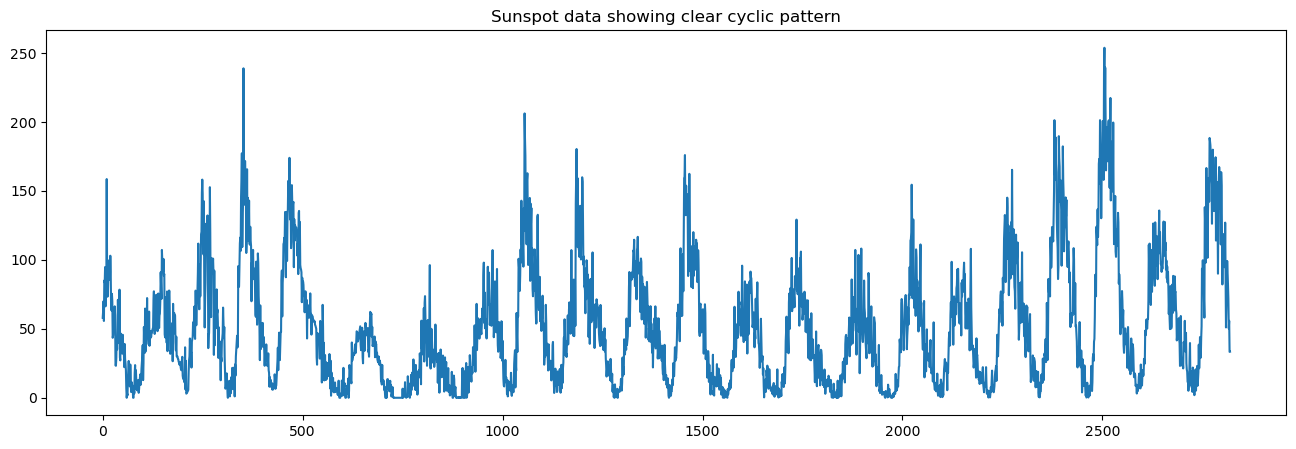

In [3]:
df = pd.read_csv('sunspots.csv')
df.head()
data = df.loc[:,'Sunspots'] #we just need the sunpot code, not the month and year.  
                            #Knowing that each entry is a month apart from the next one is sufficient.
plt.figure(figsize=(16,5))
plt.plot(data)
plt.title('Sunspot data showing clear cyclic pattern')
plt.show()

In [4]:
df.head()

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [5]:
#data = np.array(data)
data = np.array(data.values.astype('float32'))
data = data.reshape(len(data),1)

In [6]:
data.shape

(2820, 1)

In [7]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data).flatten()
data

array([0.22852638, 0.24665089, 0.2758077 , ..., 0.21985814, 0.13120566,
       0.13159968], dtype=float32)

In [8]:
# We can't use train_test_split to randomly split the data, since we need to maintain it's serial nature.  
# So let's split so that the first X% of data will be the training set, and the remaining datapoints after will be the test set.  
split_pcnt = 70
split = int(len(data)*split_pcnt/100)
Train = data[range(split)]
Test = data[split:]

In [9]:
Test.shape

(846,)

Reshape the data from one long array to a matrix of dimensions 187 (years) x 12 (months) x 1 (# variables)

In [10]:
# get indices for 13th month (remember 0-based indexing) as target for RNN to predict
time_steps = 12
Y_ind = np.arange(time_steps, len(Train), time_steps)
YTrain = Train[Y_ind]

# reshape XTrain to 3 dim matrix
rows_x = len(YTrain)
XTrain = Train[range(time_steps*rows_x)] #keep the largest multiple of 12, discard the rest
XTrain = np.reshape(XTrain, (rows_x, time_steps, 1))  #reshape to a matrix

In [11]:
XTrain.shape

(164, 12, 1)

In [12]:
# Repeat for test data:
Y_ind = np.arange(time_steps, len(Test), time_steps)
YTest = Test[Y_ind]

# reshape XTrain to 3 dim matrix
rows_x = len(YTest)
XTest = Test[range(time_steps*rows_x)] #keep the largest multiple of 12, discard the rest
XTest = np.reshape(XTest, (rows_x, time_steps, 1))  #reshape to a matrix

In [13]:
XTest.shape

(70, 12, 1)

RNN will have:
* 3 hidden layers
* hidden layers will have 12 steps
* 1 dense output layer.  
* tanh activation functions for hidden and output layers

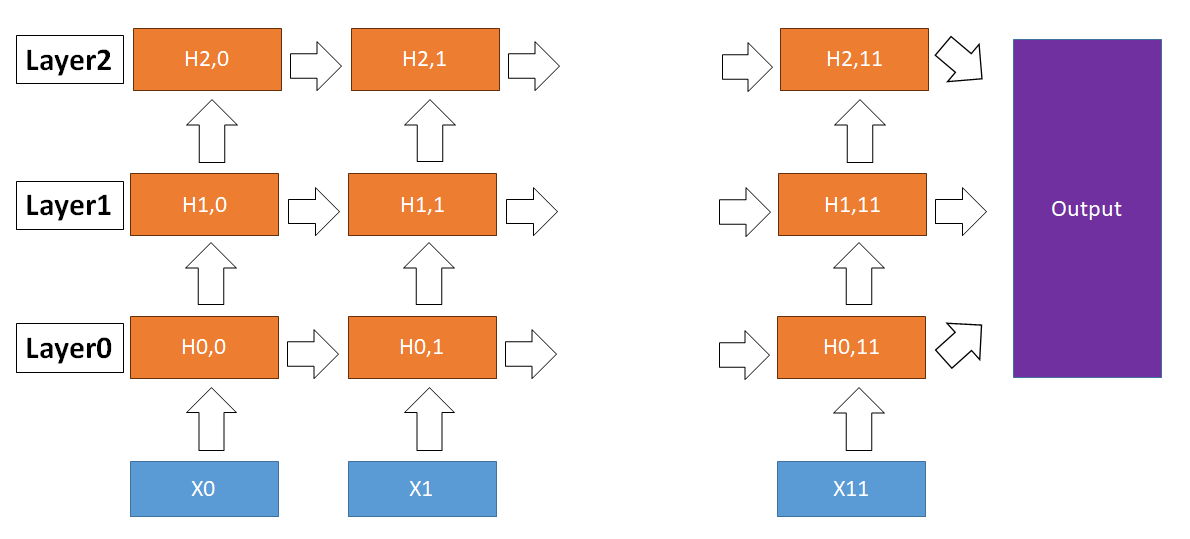

In [14]:
from tensorflow.keras.layers import Dropout
hidden_units = 3
input_shape = (time_steps,1)
model = Sequential()
model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation='tanh'))

# model.add(Dropout(0.5)) # Not using dropout because model is not overfitting...
# and it lowers performance by 2x.  Also with only 3 hidden layers, there's not...
# room to randomly shut off 50% of 3 layers.  

model.add(Dense(units=1,activation='tanh'))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(XTrain, YTrain, epochs=50, validation_data=(XTest,YTest),
          batch_size=1, verbose=2)

Epoch 1/50
164/164 - 2s - loss: 0.1393 - val_loss: 0.0264 - 2s/epoch - 12ms/step
Epoch 2/50
164/164 - 0s - loss: 0.0173 - val_loss: 0.0079 - 408ms/epoch - 2ms/step
Epoch 3/50
164/164 - 0s - loss: 0.0072 - val_loss: 0.0049 - 353ms/epoch - 2ms/step
Epoch 4/50
164/164 - 0s - loss: 0.0051 - val_loss: 0.0047 - 370ms/epoch - 2ms/step
Epoch 5/50
164/164 - 0s - loss: 0.0043 - val_loss: 0.0050 - 381ms/epoch - 2ms/step
Epoch 6/50
164/164 - 0s - loss: 0.0040 - val_loss: 0.0061 - 420ms/epoch - 3ms/step
Epoch 7/50
164/164 - 0s - loss: 0.0039 - val_loss: 0.0053 - 414ms/epoch - 3ms/step
Epoch 8/50
164/164 - 0s - loss: 0.0038 - val_loss: 0.0054 - 386ms/epoch - 2ms/step
Epoch 9/50
164/164 - 0s - loss: 0.0038 - val_loss: 0.0056 - 418ms/epoch - 3ms/step
Epoch 10/50
164/164 - 0s - loss: 0.0037 - val_loss: 0.0058 - 396ms/epoch - 2ms/step
Epoch 11/50
164/164 - 0s - loss: 0.0038 - val_loss: 0.0061 - 401ms/epoch - 2ms/step
Epoch 12/50
164/164 - 0s - loss: 0.0038 - val_loss: 0.0061 - 343ms/epoch - 2ms/step
Epo

In [15]:
# make predictions
train_predict = model.predict(XTrain)
test_predict = model.predict(XTest)

# Error of predictions
train_rmse = math.sqrt(mean_squared_error(YTrain, train_predict))
test_rmse = math.sqrt(mean_squared_error(YTest, test_predict))
# Print RMSE
print('Train RMSE: %.3f RMSE' % (train_rmse))
print('Test RMSE: %.3f RMSE' % (test_rmse))  

3/3 [==============================] - 0s 2ms/step
Train RMSE: 0.062 RMSE
Test RMSE: 0.080 RMSE


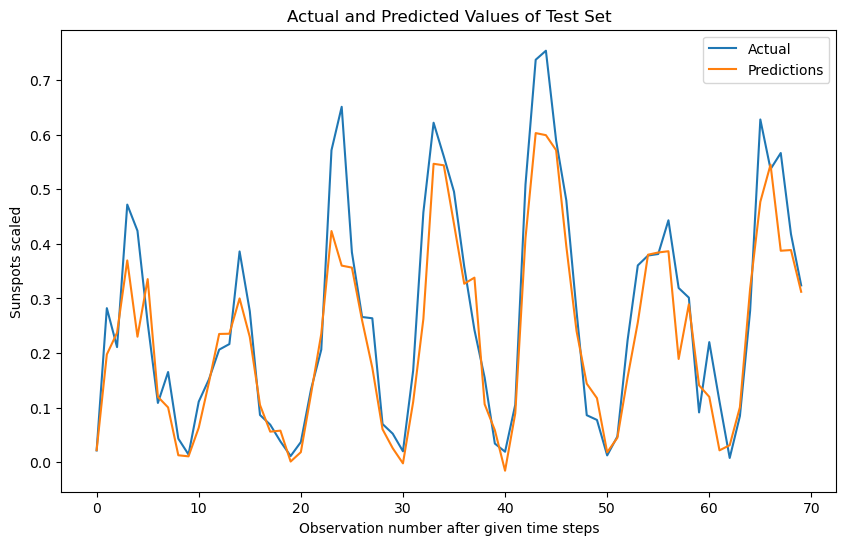

In [16]:
plt.figure(figsize=(10,6))
plt.plot(range(len(YTest)),YTest)
plt.plot(range(len(test_predict)),test_predict)
plt.xlabel('Observation number after given time steps')
plt.ylabel('Sunspots scaled')
plt.title('Actual and Predicted Values of Test Set')
plt.legend(['Actual', 'Predictions'])
plt.show()

### LSTM Example
We are covering the theory of LSTM's, but we can go over an example of how to use it.  

In [17]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from keras.losses import SparseCategoricalCrossentropy
model = Sequential()
model.add(LSTM(hidden_units, input_shape=(time_steps,1)))
model.add(Dense(units=1,activation='tanh'))
print(model.summary())

model.compile(
    loss='mean_squared_error',
    optimizer="adam",
)

model.fit(XTrain, YTrain, epochs=50, validation_data=(XTest,YTest),
          batch_size=1, verbose=2)

# make predictions
train_predict = model.predict(XTrain)
test_predict = model.predict(XTest)

# Error of predictions
train_rmse = math.sqrt(mean_squared_error(YTrain, train_predict))
test_rmse = math.sqrt(mean_squared_error(YTest, test_predict))
# Print RMSE
print('Train RMSE: %.3f RMSE' % (train_rmse))
print('Test RMSE: %.3f RMSE' % (test_rmse))  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3)                 60        
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
164/164 - 3s - loss: 0.0101 - val_loss: 0.0182 - 3s/epoch - 19ms/step
Epoch 2/50
164/164 - 1s - loss: 0.0063 - val_loss: 0.0120 - 535ms/epoch - 3ms/step
Epoch 3/50
164/164 - 1s - loss: 0.0054 - val_loss: 0.0102 - 523ms/epoch - 3ms/step
Epoch 4/50
164/164 - 1s - loss: 0.0051 - val_loss: 0.0096 - 527ms/epoch - 3ms/step
Epoch 5/50
164/164 - 1s - loss: 0.0050 - val_loss: 0.0086 - 520ms/epoch - 3ms/step
Epoch 6/50
164/164 - 1s - loss: 0.00

### RNN with DPA Data 
***curiosity points (15 points)***
Load the shortened DPA dataset (59 time-series variables) and try to predict the hamming weight using a simple RNN network.  Solution shown below.  

In [18]:
# Read in the DPA datasest from Module 1
X = pd.read_csv("DPA_Data_Small.csv").values
y = pd.read_csv("DPA_target.csv", index_col=0)
y = np.array(y).ravel()

In [19]:
class1 = 2
class2 = 6

In [20]:
X_2class = X[((y==class1) | (y==class2)),:]
y_2class = y[(y==class1) | (y==class2)]
X_2class.shape

(224, 59)

In [21]:
# Need to convert classes to 0 and 1
y_2class[y_2class==class1]=0
y_2class[y_2class==class2]=1

In [22]:
# Split to training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_2class, y_2class, test_size=0.3, random_state=1)

In [23]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
nrow,ncol = X_train.shape
X_train = np.reshape(X_train, (nrow, ncol, 1)) 
nrow,ncol = X_test.shape
X_test = np.reshape(X_test, (nrow, ncol, 1)) 

In [24]:
hidden_units = 3
input_shape = (ncol,1)
model = Sequential()
model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation='tanh'))

# model.add(Dropout(0.5)) # Not using dropout because model is not overfitting...
# and it lowers performance by 2x.  Also with only 3 hidden layers, there's not...
# room to randomly shut off 50% of 3 layers.  

model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(X_train, y_train, epochs=50, validation_data=(X_test,y_test),
          batch_size=1, verbose=2)

Epoch 1/50
156/156 - 3s - loss: 0.7186 - val_loss: 0.6274 - 3s/epoch - 17ms/step
Epoch 2/50
156/156 - 1s - loss: 0.5453 - val_loss: 0.5116 - 1s/epoch - 7ms/step
Epoch 3/50
156/156 - 1s - loss: 0.4960 - val_loss: 0.5042 - 1s/epoch - 7ms/step
Epoch 4/50
156/156 - 1s - loss: 0.4651 - val_loss: 0.4729 - 972ms/epoch - 6ms/step
Epoch 5/50
156/156 - 1s - loss: 0.4470 - val_loss: 0.4648 - 969ms/epoch - 6ms/step
Epoch 6/50
156/156 - 1s - loss: 0.4292 - val_loss: 0.4525 - 963ms/epoch - 6ms/step
Epoch 7/50
156/156 - 1s - loss: 0.4175 - val_loss: 0.4261 - 980ms/epoch - 6ms/step
Epoch 8/50



KeyboardInterrupt



In [ ]:
# make predictions
ypred = model.predict(X_test)
ypred = ypred.round()

from sklearn.metrics import classification_report
print(classification_report(y_test, ypred))